## Basic Filter Methods plus LASSO pipeline
### Putting it all together

In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [2]:
# load the Santander customer satisfaction dataset from Kaggle

data = pd.read_csv('santander.csv')
data.shape

(76020, 371)

In [3]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['TARGET'], axis=1),
    data['TARGET'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((53214, 370), (22806, 370))

In [4]:
# I keep a copy of the dataset with all the variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_original = X_train.copy()
X_test_original = X_test.copy()

### Remove constant features

In [5]:
# remove constant features
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]

X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((53214, 332), (22806, 332))

### Remove quasi-constant features

In [6]:
# remove quasi-constant features
sel = VarianceThreshold(
    threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit(X_train)  # fit finds the features with low variance

sum(sel.get_support()) # how many not quasi-constant?

268

In [7]:
features_to_keep = X_train.columns[sel.get_support()]

In [8]:
# we can then remove the features like this
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((53214, 268), (22806, 268))

In [9]:
# sklearn transformations lead to numpy arrays
# here I transform the arrays back to dataframes
# please be mindful of getting the columns assigned
# correctly

X_train= pd.DataFrame(X_train)
X_train.columns = features_to_keep

X_test= pd.DataFrame(X_test)
X_test.columns = features_to_keep

### Remove duplicated features

In [10]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


16

In [11]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((53214, 252), (22806, 252))

In [12]:
# I keep a copy of the dataset except constant and duplicated variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

### Remove correlated features

In [13]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  133


In [14]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((53214, 119), (22806, 119))

In [15]:
# keep a copy of the dataset at  this stage
X_train_corr = X_train.copy()
X_test_corr = X_test.copy()

### Remove features using univariate ROC-AUC

In [18]:
# find important features using univariate roc-auc

# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set

roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

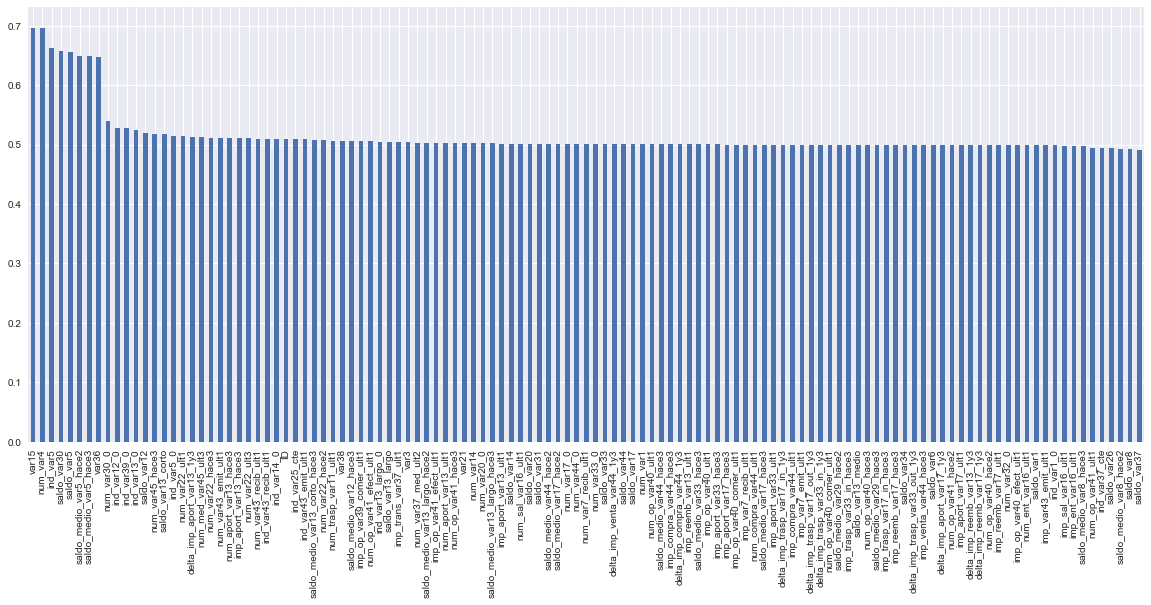

In [19]:
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [20]:
# by removing features with univariate roc_auc == 0.5
# we remove another 30 features

selected_feat = roc_values[roc_values>0.5]
len(selected_feat), X_train.shape[1]

(90, 119)

### Remove features using Lasso

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [24]:
# fit a lasso and selet features, make sure to select l1
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
sel_.fit(scaler.transform(X_train), y_train)

# remove features with zero coefficient from dataset
# and parse again as dataframe (output of sklearn is
# numpy array)
X_train_lasso = pd.DataFrame(sel_.transform(X_train))
X_test_lasso = pd.DataFrame(sel_.transform(X_test))

# add the columns name
X_train_lasso.columns = X_train.columns[(sel_.get_support())]
X_test_lasso.columns = X_train.columns[(sel_.get_support())]

In [25]:
X_train_lasso.shape, X_test_lasso.shape

((53214, 91), (22806, 91))

### Compare the performance in machine learning algorithms

In [26]:
# create a function to build random forests and compare performance in train and test set

def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [30]:
# original
run_randomForests(X_train_original.drop(labels=['ID'], axis=1),
                  X_test_original.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8012315676132568
Test set
Random Forests roc-auc: 0.7900499757912425


In [31]:
# filter methods - basic
run_randomForests(X_train_basic_filter.drop(labels=['ID'], axis=1),
                  X_test_basic_filter.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8016570464386661
Test set
Random Forests roc-auc: 0.7910330692426437


In [32]:
# filter methods - correlation
run_randomForests(X_train_corr.drop(labels=['ID'], axis=1),
                  X_test_corr.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8073914001626228
Test set
Random Forests roc-auc: 0.793766724733034


In [33]:
# filter methods - univariate roc-auc
run_randomForests(X_train[selected_feat.index],
                  X_test_corr[selected_feat.index],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8105671870819526
Test set
Random Forests roc-auc: 0.7985492537265694


In [34]:
# embedded methods - Lasso
run_randomForests(X_train_lasso.drop(labels=['ID'], axis=1),
                  X_test_lasso.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8097705382245719
Test set
Random Forests roc-auc: 0.7981128314010972


Selecting features using Lasso or univariate feature selection using the roc-auc lead to very similar results:

univariate: 0.7985

Lasso: 0.7981

The difference is in the 4th decimal, which is likely within the error (remember that all models have an error, which you could estimate doing cross-validation).

Therefore, for this dataset, any of the 2 approaches would lead to a similar result in terms of performance and final number of features used (90 and 91 respectively).

Let's have a look at the performance of logistic regression.

In [35]:
# create a function to build logistic regression and compare performance in train and test set

def run_logistic(X_train, X_test, y_train, y_test):
    # function to train and test the performance of logistic regression
    logit = LogisticRegression(random_state=44)
    logit.fit(X_train, y_train)
    print('Train set')
    pred = logit.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = logit.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [36]:
# original
scaler = StandardScaler().fit(X_train_original.drop(labels=['ID'], axis=1))

run_logistic(scaler.transform(X_train_original.drop(labels=['ID'], axis=1)),
             scaler.transform(X_test_original.drop(labels=['ID'], axis=1)),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8069992623682241
Test set
Logistic Regression roc-auc: 0.7936268147072499


C:\Users\Sole\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [37]:
# filter methods - basic
scaler = StandardScaler().fit(X_train_basic_filter.drop(labels=['ID'], axis=1))

run_logistic(scaler.transform(X_train_basic_filter.drop(labels=['ID'], axis=1)),
             scaler.transform(X_test_basic_filter.drop(labels=['ID'], axis=1)),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8063198115788011
Test set
Logistic Regression roc-auc: 0.7932259508684169


C:\Users\Sole\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [38]:
# filter methods - correlation
scaler = StandardScaler().fit(X_train_corr.drop(labels=['ID'], axis=1))

run_logistic(scaler.transform(X_train_corr.drop(labels=['ID'], axis=1)),
             scaler.transform(X_test_corr.drop(labels=['ID'], axis=1)),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.7964877573303559
Test set
Logistic Regression roc-auc: 0.7929025260668946


In [39]:
# filter methods - univariate roc-auc
scaler = StandardScaler().fit(X_train[selected_feat.index])

run_logistic(scaler.transform(X_train[selected_feat.index]),
             scaler.transform(X_test_corr[selected_feat.index]),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.7928875332009033
Test set
Logistic Regression roc-auc: 0.7946610594040128


In [40]:
# embedded methods - Lasso
run_randomForests(X_train_lasso.drop(labels=['ID'], axis=1),
                  X_test_lasso.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8097705382245719
Test set
Random Forests roc-auc: 0.7981128314010972


For logistic regression, Lasso provides a better selection of features:

univariate: 0.7946

Lasso: 0.7981

In fact, Lasso feature selection renders the same performance for both random forests and logistic regressions, whereas the univariate roc-auc selects a subset of features that produces a less performing logistic regression model. So if your final model is a logistic regression for its simplicity and interpretability, the features selected by Lasso are the ones to be used.

This is not surprising, because Lasso is a regularisation for linear models. Then, it is expected that the feature space selected is the optimal for a linear algorithm.

Having said this, 90 features are still a lot of features, so stay tuned in the course to see if we can reduce this further.

That is all for this lecture. I hope you enjoyed it!